<a href="https://colab.research.google.com/github/pdrobny/Potential_Talents/blob/main/P3_part2_rev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install scipy seaborn
!pip install torch torchvision torchaudio
!pip install tensorflow
!pip install torchview

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import random
import requests
import sys
import regex as re
import plotly.express as px
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, make_scorer, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text
from sklearn.feature_selection import RFE
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore', category=UserWarning)
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchview import draw_graph
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder


print(torch.__version__)
tf.__version__


2.6.0+cu124


'2.18.0'

In [3]:
df = pd.read_csv('talents.csv')
df

,id,title,sentence_bert_cossim
0,1,innovative and driven professional seeking a r...,1.000000
1,431,aspiring data science professional focused on ...,0.769162
2,544,data analyst data scientist business analyst d...,0.768222
3,833,data analyst turning complex data into actiona...,0.745245
4,199,ms in information systems northeastern univers...,0.727268
...,...,...,...
1260,648,research specialist university of rochester di...,0.079923
1261,730,medical biller at brick pediatric group,0.072848
1262,990,ingeniero elctrico,0.067254
1263,296,company owner at armstrong cleans carpets,0.056890


In [4]:
df['score'] = (df['sentence_bert_cossim'] * 100).astype(int)
df

,id,title,sentence_bert_cossim,score
0,1,innovative and driven professional seeking a r...,1.000000,100
1,431,aspiring data science professional focused on ...,0.769162,76
2,544,data analyst data scientist business analyst d...,0.768222,76
3,833,data analyst turning complex data into actiona...,0.745245,74
4,199,ms in information systems northeastern univers...,0.727268,72
...,...,...,...,...
1260,648,research specialist university of rochester di...,0.079923,7
1261,730,medical biller at brick pediatric group,0.072848,7
1262,990,ingeniero elctrico,0.067254,6
1263,296,company owner at armstrong cleans carpets,0.056890,5


In [5]:
df_score = df[['id','title','score']]
df_score

,id,title,score
0,1,innovative and driven professional seeking a r...,100
1,431,aspiring data science professional focused on ...,76
2,544,data analyst data scientist business analyst d...,76
3,833,data analyst turning complex data into actiona...,74
4,199,ms in information systems northeastern univers...,72
...,...,...,...
1260,648,research specialist university of rochester di...,7
1261,730,medical biller at brick pediatric group,7
1262,990,ingeniero elctrico,6
1263,296,company owner at armstrong cleans carpets,5


In [6]:
# Sort the DataFrame by score in descending order
df_score = df_score.sort_values('score', ascending=False)

# Replace the top 5 scores with 100
df_score.loc[df_score.index[:5], 'score'] = 100

# If you want to reset the index after modifying
df_score = df_score.reset_index(drop=True)

df_score


,id,title,score
0,1,innovative and driven professional seeking a r...,100
1,431,aspiring data science professional focused on ...,100
2,544,data analyst data scientist business analyst d...,100
3,833,data analyst turning complex data into actiona...,100
4,199,ms in information systems northeastern univers...,100
...,...,...,...
1260,648,research specialist university of rochester di...,7
1261,730,medical biller at brick pediatric group,7
1262,990,ingeniero elctrico,6
1263,296,company owner at armstrong cleans carpets,5


In [7]:
# prompt: create a learn to rank model with ranknet and pytorch based on df['score']

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F # Import necessary module

# set torch seed number
torch.manual_seed(6680022727077058851)
#torch.manual_seed(42)
print(torch.initial_seed())
# Assuming df_score is already defined as in the previous code

# Prepare the data
X = df_score[['title']]  # Use only numerical features for now
y = df_score['score'].values

# 1. Encode the 'title' column using LabelEncoder
encoder = SentenceTransformer('all-mpnet-base-v2')
X = encoder.encode(X['title'].tolist())

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32, requires_grad=True)  # Now X contains numerical data and requires gradient
y = torch.tensor(y, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



6680022727077058851


In [20]:
# Define the RankNet model
class RankNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RankNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.fc_layers = 2 # Define fc_layers
        self.activation = nn.ReLU6() # Define activation

    def forward(self, input1, input2):
        # from 1 to N - 1 layer, use ReLU as activation function
        for i in range(1, self.fc_layers):
            fc = getattr(self, 'fc' + str(i))
            input1 = F.relu(fc(input1))
            input2 = F.relu(fc(input2))

        # last layer use ReLU6 Activation Function
        fc = getattr(self, 'fc' + str(self.fc_layers))
        input1 = self.activation(fc(input1))
        input2 = self.activation(fc(input2))

        # normalize input1 - input2 as a probability that doc1 should rank higher than doc2
        return torch.sigmoid(input1 - input2)

# Initialize the model, loss function, and optimizer
input_dim = X.shape[1]  # Number of features
hidden_dim = 256 # Adjust as needed
model = RankNet(input_dim, hidden_dim)
criterion = nn.MarginRankingLoss(margin=1.0)  # Pairwise Ranking Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = []
# Training loop
num_epochs = 600  # Adjust as needed
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(dataloader):

        # Get random pairs of inputs within the batch
        # Create a list of indices
        indices = torch.randperm(inputs.shape[0])

        # Ensure both input tensors have the same size by taking the minimum size
        min_size = min(indices[:inputs.shape[0] // 2].shape[0], indices[inputs.shape[0] // 2:].shape[0])

        # Split the indices into two lists to create pairs, ensuring equal size
        indices1 = indices[:min_size]  # Take the first min_size indices
        indices2 = indices[inputs.shape[0] // 2 : inputs.shape[0] // 2 + min_size]  # Take min_size indices from the second half

        # Get the input pairs using the indices
        input1 = inputs[indices1]
        input2 = inputs[indices2]

        # Get the corresponding target pairs
        target1 = targets[indices1]
        target2 = targets[indices2]


        optimizer.zero_grad()
        # Get the model's predictions for the pairs
        outputs = model(input1, input2)

        # Assume you have a function to calculate pairwise loss
        # For example, using a margin ranking loss
        #target = torch.sign(target1 - target2) # Create target for pairwise ranking
        target = (target1 > target2).float() # Create target for pairwise ranking
        # Ensure inputs to the criterion require gradients
        loss = criterion(outputs.squeeze(), torch.zeros_like(outputs.squeeze(), requires_grad=True), target)

        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())

    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [21]:

# Loop through each row in df_score
ref_index = 0 # Reference title
for index, row in df_score.iterrows():

    if index == ref_index:
      continue

    comp_index = index
    ref_feature = X[[ref_index]].type(torch.float32)
    comp_feature = X[[comp_index]].type(torch.float32)

    with torch.no_grad():
        predicted_score = model(ref_feature, comp_feature)

    df_score.loc[index, 'RankNet'] = predicted_score.item()


df_score

,id,title,score,RankNet
0,1,innovative and driven professional seeking a r...,100,NaN
1,431,aspiring data science professional focused on ...,100,0.500000
2,544,data analyst data scientist business analyst d...,100,0.500000
3,833,data analyst turning complex data into actiona...,100,0.500000
4,199,ms in information systems northeastern univers...,100,0.500000
...,...,...,...,...
1260,648,research specialist university of rochester di...,7,0.997527
1261,730,medical biller at brick pediatric group,7,0.997527
1262,990,ingeniero elctrico,6,0.997527
1263,296,company owner at armstrong cleans carpets,5,0.997527


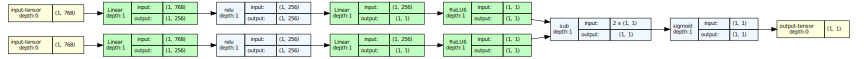

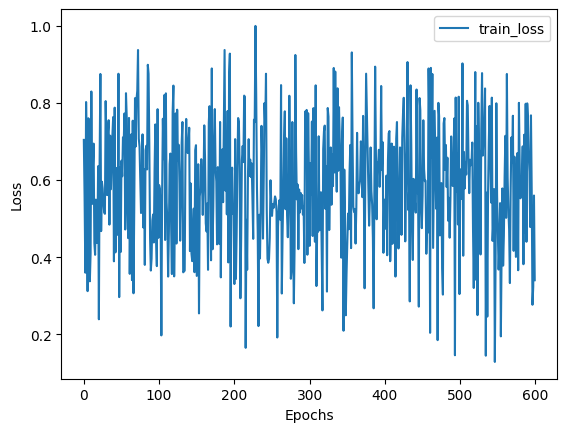

In [22]:
## Plot Loss
plt.plot(train_loss, label='train_loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show

## Plot model architecutre
model_graph = draw_graph(model, input_data = [ref_feature, comp_feature], graph_dir = "LR", save_graph = True, graph_name="RankNet")
model_graph.visual_graph